# ETH


### Import th∆∞ vi·ªán


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from typing import Tuple

## ETH Dataset


### Import csv


In [2]:
# ƒê·ªçc file ETH
file_path = "D:\\github_desktop\\Cryptocurrency-Price-Prediction\\Cryptocurrency\\Dataset\\Ethereum Historical Data.csv"

data = pd.read_csv(file_path)

# Lo·∫°i b·ªè d·∫•u ph·∫©y v√† chuy·ªÉn ƒë·ªïi th√†nh float cho Price v√† Open
for col in ['Price', 'Open']:
    data[col] = data[col].str.replace(',', '', regex=False).astype(float)

# X·ª≠ l√Ω c·ªôt 'Vol.' ch·ª©a h·∫≠u t·ªë 'K', 'M', 'B' th√†nh s·ªë th·ª±c
def convert_volume(val):
    val = str(val).replace(',', '').strip()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'B' in val:
        return float(val.replace('B', '')) * 1_000_000_000
    else:
        try:
            return float(val)
        except ValueError:
            return np.nan  # Tr∆∞·ªùng h·ª£p val l√† '' ho·∫∑c kh√¥ng chuy·ªÉn ƒë∆∞·ª£c

data['Vol.'] = data['Vol.'].apply(convert_volume)

# Ki·ªÉm tra NaN ban ƒë·∫ßu trong Vol.
print(f"Tr∆∞·ªõc khi x·ª≠ l√Ω, s·ªë NaN ·ªü Vol.: {data['Vol.'].isna().sum()}")

# N·ªôi suy gi√° tr·ªã Vol. (ch·ªâ sau khi ƒë√£ convert sang s·ªë)
data['Vol.'] = data['Vol.'].interpolate(mdataod='linear')

# ƒêi·ªÅn 0 cho NaN c√≤n l·∫°i
data['Vol.'] = data['Vol.'].fillna(0)

# Ki·ªÉm tra NaN sau x·ª≠ l√Ω
print(f"Sau khi x·ª≠ l√Ω, s·ªë NaN ·ªü Vol.: {data['Vol.'].isna().sum()}")

# ƒê·ªïi Date sang datetime v√† ƒë·∫∑t l√†m index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Th√¥ng tin d·ªØ li·ªáu
print("Data shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nFirst 5 rows:")
print(data[['Price', 'Open', 'Vol.']].head())

print(f"T·ªïng s·ªë d·ªØ li·ªáu: {len(data)} d√≤ng")

Tr∆∞·ªõc khi x·ª≠ l√Ω, s·ªë NaN ·ªü Vol.: 8
Sau khi x·ª≠ l√Ω, s·ªë NaN ·ªü Vol.: 0
Data shape: (3370, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
            Price   Open     Vol.
Date                             
2016-03-10  11.75  11.20      0.0
2016-03-11  11.95  11.75    180.0
2016-03-12  12.92  11.95    830.0
2016-03-13  15.07  12.92   1300.0
2016-03-14  12.50  15.07  92180.0
T·ªïng s·ªë d·ªØ li·ªáu: 3370 d√≤ng


### Chia 7:3


#### Chu·∫©n h√≥a d·ªØ li·ªáu


In [3]:
# Chu·∫©n h√≥a d·ªØ li·ªáu
# L·∫•y 3 c·ªôt Price, Open, Vol. ƒë·ªÉ l√†m ƒë·∫ßu v√†o v√† Price l√†m ƒë·∫ßu ra
input_features = data[['Price', 'Open', 'Vol.']].values
target_feature = data[['Price']].values

# √Åp d·ª•ng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# √Åp d·ª•ng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

In [4]:
# Chia d·ªØ li·ªáu train/test theo t·ª∑ l·ªá 7:3
train_size = int(len(data) * 0.7)
train_data = data.iloc[0:train_size,:]
test_data = data.iloc[train_size:len(data),:]

# Chia d·ªØ li·ªáu ƒë√£ chu·∫©n h√≥a
scaled_train_input = scaled_input[0:train_size,:]
scaled_test_input = scaled_input[train_size:,:]
scaled_train_target = scaled_target[0:train_size,:]
scaled_test_target = scaled_target[train_size:,:]

print(f"K√≠ch th∆∞·ªõc t·∫≠p train: {len(train_data)}")
print(f"K√≠ch th∆∞·ªõc t·∫≠p test: {len(test_data)}")

K√≠ch th∆∞·ªõc t·∫≠p train: 2359
K√≠ch th∆∞·ªõc t·∫≠p test: 1011


#### X√¢y d·ª±ng m√¥ h√¨nh RNN


In [5]:
def build_rnn_model_with_regularization(time_step: int, num_features: int) -> Sequential:
    """
    X√¢y d·ª±ng m√¥ h√¨nh RNN v·ªõi regularization

    Args:
        time_step: S·ªë time steps ƒë·ªÉ nh√¨n v·ªÅ qu√° kh·ª©
        num_features: S·ªë features ƒë·∫ßu v√†o (Price, Open, Vol = 3)

    Returns:
        Sequential model
    """
    model = Sequential()

    # SimpleRNN layer v·ªõi regularization
    model.add(SimpleRNN(
        units=50,                       # S·ªë neurons
        input_shape=(time_step, num_features),  # (50, 3)
        kernel_regularizer=regularizers.l2(0.001),    # L2 regularization
        return_sequences=False           # Ch·ªâ c·∫ßn output cu·ªëi c√πng
    ))

    # Dropout ƒë·ªÉ tr√°nh overfitting
    model.add(Dropout(0.3))

    # Dense layer ·∫©n
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer: d·ª± ƒëo√°n 1 gi√° tr·ªã (Price)
    model.add(Dense(1))

    # Optimizer v·ªõi learning rate nh·ªè
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [6]:
# H√†m t·∫°o d·ªØ li·ªáu time series v·ªõi multiple features
def create_multivariate_time_series_data(input_data: np.ndarray, target_data: np.ndarray, time_step: int) -> Tuple[np.ndarray, np.ndarray]:
    X_data, y_data = [], []
    for i in range(len(input_data) - time_step):
        X_data.append(input_data[i:(i + time_step), :])  # L·∫•y t·∫•t c·∫£ features
        y_data.append(target_data[i + time_step, 0])     # Ch·ªâ l·∫•y Price
    return np.array(X_data), np.array(y_data)

In [7]:
# H√†m d·ª± ƒëo√°n v·ªõi multiple features
def forecast_multivariate_prices(model: Sequential, input_data: np.ndarray, time_step: int,
                                forecast_days: int, scaler_target: MinMaxScaler) -> np.ndarray:
    temp_input = input_data[-time_step:].reshape(1, time_step, input_data.shape[1])
    lst_output = []

    for _ in range(forecast_days):
        predicted_price = model.predict(temp_input, verbose=0)
        lst_output.append(predicted_price[0].tolist())

        # T·∫°o input m·ªõi cho prediction ti·∫øp theo
        # Gi·∫£ s·ª≠ c√°c features kh√°c kh√¥ng ƒë·ªïi, ch·ªâ c·∫≠p nh·∫≠t Price
        new_row = temp_input[0, -1, :].copy()
        new_row[0] = predicted_price[0, 0]  # C·∫≠p nh·∫≠t Price prediction

        temp_input = np.append(temp_input[:, 1:, :],
                              new_row.reshape(1, 1, input_data.shape[1]), axis=1)

    # Chuy·ªÉn ƒë·ªïi lst_output th√†nh numpy array v√† inverse transform
    lst_output = np.array(lst_output).reshape(-1, 1)
    return scaler_target.inverse_transform(lst_output)

#### Hu·∫•n luy·ªán m√¥ h√¨nh


In [8]:
# T·∫°o d·ªØ li·ªáu train v√† test v·ªõi time_step = 50
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# X√¢y d·ª±ng m√¥ h√¨nh RNN
model_rnn = build_rnn_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks ƒë·ªÉ t·ªëi ∆∞u h√≥a
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Hu·∫•n luy·ªán m√¥ h√¨nh
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

X_train shape: (2309, 50, 3)
y_train shape: (2309,)
X_test shape: (961, 50, 3)
y_test shape: (961,)
Epoch 1/60


c:\Users\Hii\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


145/145 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 7ms/step - loss: 0.3007 - mae: 0.2994 - val_loss: 0.0235 - val_mae: 0.0937 - learning_rate: 1.0000e-04
Epoch 2/60
145/145 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step - loss: 0.0362 - mae: 0.0957 - val_loss: 0.0083 - val_mae: 0.0406 - learning_rate: 1.0000e-04
Epoch 3/60
145/145 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step - loss: 0.0295 - mae: 0.0770 - val_loss: 0.0075 - val_mae: 0.0362 - learning_rate: 1.0000e-04
Epoch 4/60
145/145 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 7ms/step - loss: 0.0204 - mae: 0.0632 - val_loss: 0.0070 - val_mae: 0.0292 - learning_rate: 1.0000e-04
Epoch 5/60
145/145 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step - loss: 0.0215 - mae: 0.0625 - val_loss: 0.0067 - val_mae: 0.0269 - learning_rate: 1.0000e-04
Epoch 6/60
145/145 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1

#### ƒê√°nh gi√° m√¥ h√¨nh


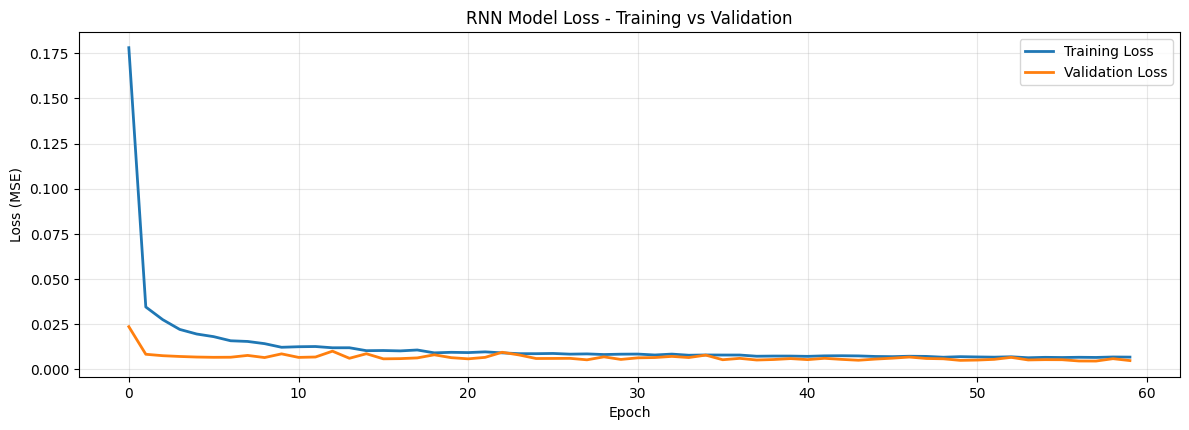

Epoch t·ªët nh·∫•t: 58 v·ªõi val_loss: 0.004502


In [9]:
# V·∫Ω val_loss ƒë·ªÉ ƒë√°nh gi√° overfitting
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_rnn.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_rnn.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('RNN Model Loss - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# T√¨m epoch c√≥ val_loss th·∫•p nh·∫•t
best_epoch = np.argmin(history_rnn.history['val_loss']) + 1
best_val_loss = min(history_rnn.history['val_loss'])
print(f"Epoch t·ªët nh·∫•t: {best_epoch} v·ªõi val_loss: {best_val_loss:.6f}")

#### D·ª± ƒëo√°n v√† tr·ª±c quan h√≥a


31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step


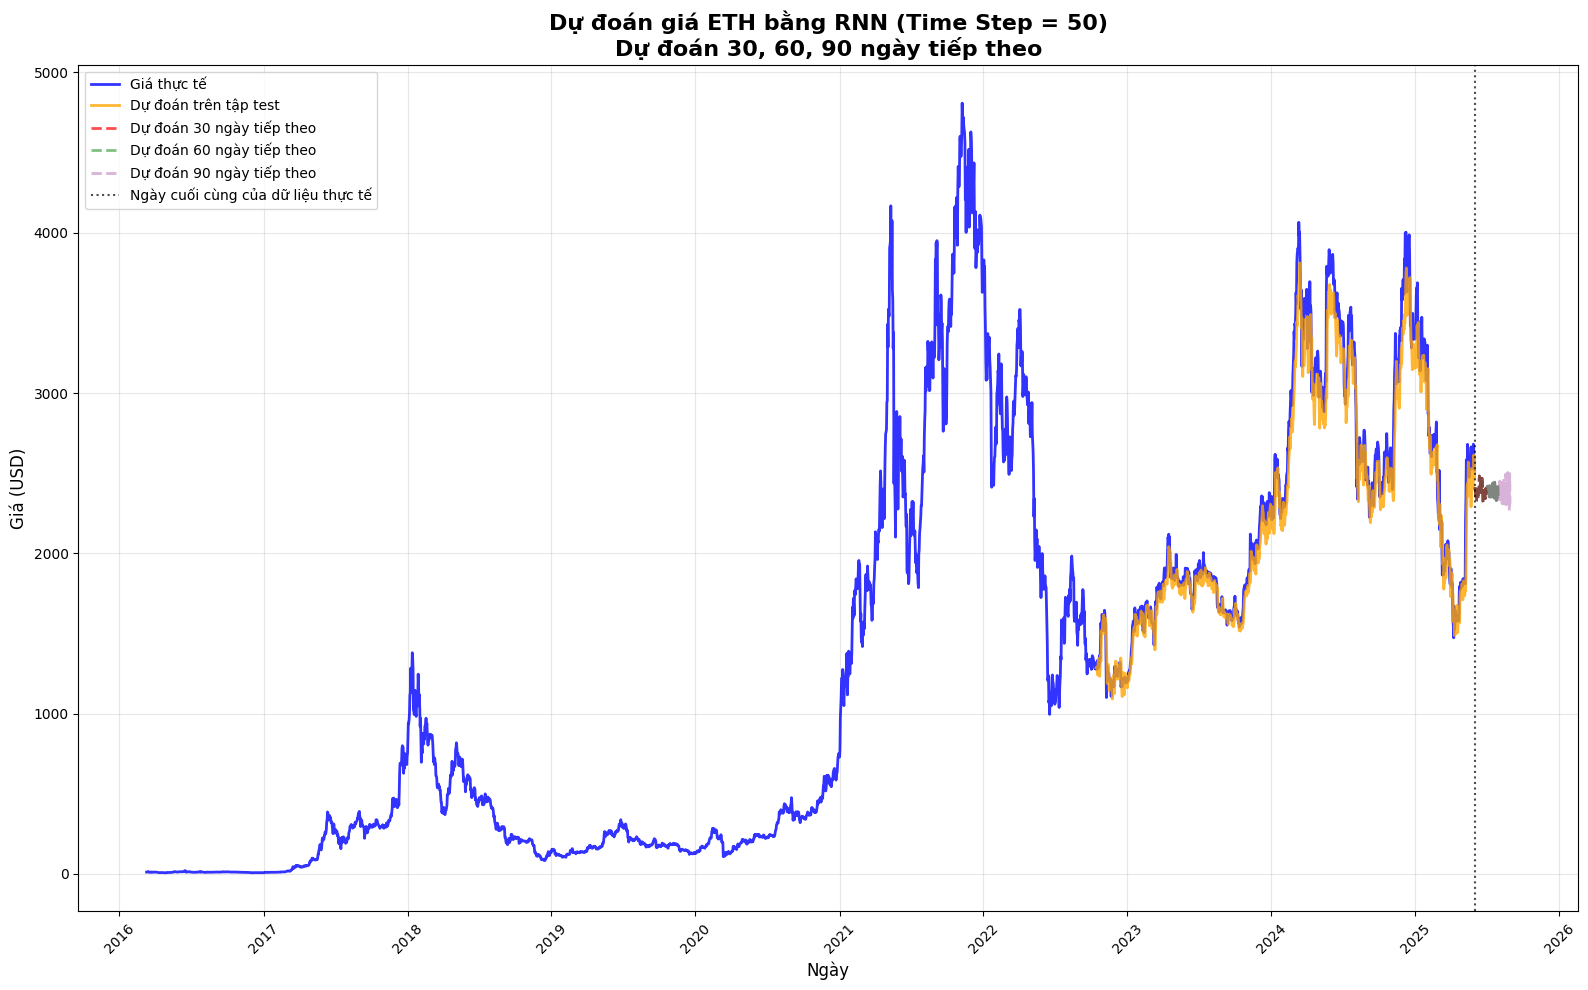

In [10]:
# D·ª± ƒëo√°n 30, 60, 90 ng√†y ti·∫øp theo
last_data_scaled = scaled_test_input[-time_step:]

forecasted_prices_30 = forecast_multivariate_prices(model_rnn, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_rnn, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_rnn, last_data_scaled, time_step, 90, scaler_target)

# D·ª± ƒëo√°n gi√° tr√™n t·∫≠p ki·ªÉm tra
test_predict_scaled = model_rnn.predict(X_test)
test_predict_rnn = scaler_target.inverse_transform(test_predict_scaled)

# T·∫°o DataFrame cho c√°c d·ª± ƒëo√°n
forecast_dates_30 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Tr·ª±c quan h√≥a k·∫øt qu·∫£
plt.figure(figsize=(16, 10))

# V·∫Ω gi√° th·ª±c t·∫ø
plt.plot(data.index, data['Price'], label='Gi√° th·ª±c t·∫ø', color='blue', linewidth=2, alpha=0.8)

# V·∫Ω d·ª± ƒëo√°n tr√™n t·∫≠p test
plt.plot(test_data.index[time_step:], test_predict_rnn,
         label='D·ª± ƒëo√°n tr√™n t·∫≠p test', color='orange', linewidth=2, alpha=0.8)

# V·∫Ω c√°c d·ª± ƒëo√°n t∆∞∆°ng lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='D·ª± ƒëo√°n 30 ng√†y ti·∫øp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='D·ª± ƒëo√°n 60 ng√†y ti·∫øp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='D·ª± ƒëo√°n 90 ng√†y ti·∫øp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Th√™m ƒë∆∞·ªùng th·∫≥ng ƒë·ª©ng ƒë·ªÉ ph√¢n bi·ªát v√πng d·ªØ li·ªáu
plt.axvline(x=data.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ng√†y cu·ªëi c√πng c·ªßa d·ªØ li·ªáu th·ª±c t·∫ø')

plt.title(f'D·ª± ƒëo√°n gi√° ETH b·∫±ng RNN (Time Step = {time_step})\nD·ª± ƒëo√°n 30, 60, 90 ng√†y ti·∫øp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ng√†y', fontsize=12)
plt.ylabel('Gi√° (USD)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# ƒê√°nh gi√° m√¥ h√¨nh
# L·∫•y gi√° tr·ªã th·ª±c t·∫ø tr√™n t·∫≠p test
y_test_actual = test_data['Price'].values[time_step:]

# T√≠nh to√°n c√°c metrics
mape = mean_absolute_percentage_error(y_test_actual, test_predict_rnn.flatten())
mse = mean_squared_error(y_test_actual, test_predict_rnn.flatten())
rmse = np.sqrt(mse)

print(f'K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh RNN (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'S·ªë epochs hu·∫•n luy·ªán: {len(history_rnn.history["loss"])}')

# Hi·ªÉn th·ªã th√¥ng tin d·ª± ƒëo√°n 30 ng√†y
print(f'\nD·ª± ƒëo√°n gi√° ETH 30 ng√†y ti·∫øp theo:')
print(f'Gi√° cao nh·∫•t: ${forecasted_prices_30.max():.2f}')
print(f'Gi√° th·∫•p nh·∫•t: ${forecasted_prices_30.min():.2f}')
print(f'Gi√° trung b√¨nh: ${forecasted_prices_30.mean():.2f}')

K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh RNN (Time Step = 50):
MAPE: 0.04%
MSE: 22888.79
RMSE: 151.29
S·ªë epochs hu·∫•n luy·ªán: 60

D·ª± ƒëo√°n gi√° ETH 30 ng√†y ti·∫øp theo:
Gi√° cao nh·∫•t: $2482.60
Gi√° th·∫•p nh·∫•t: $2312.03
Gi√° trung b√¨nh: $2393.18


### Chia 8:2


#### Chu·∫©n h√≥a d·ªØ li·ªáu 8:2


In [12]:
# Chu·∫©n h√≥a d·ªØ li·ªáu
# L·∫•y 3 c·ªôt Price, Open, Vol. ƒë·ªÉ l√†m ƒë·∫ßu v√†o v√† Price l√†m ƒë·∫ßu ra
input_features = data[['Price', 'Open', 'Vol.']].values
target_feature = data[['Price']].values

# √Åp d·ª•ng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# √Åp d·ª•ng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

In [13]:
# Chia d·ªØ li·ªáu train/test theo t·ª∑ l·ªá 8:2
train_size_82 = int(len(data) * 0.8)
train_data_82 = data.iloc[0:train_size_82,:]
test_data_82 = data.iloc[train_size_82:len(data),:]

# Chia d·ªØ li·ªáu ƒë√£ chu·∫©n h√≥a
scaled_train_input_82 = scaled_input[0:train_size_82,:]
scaled_test_input_82 = scaled_input[train_size_82:,:]
scaled_train_target_82 = scaled_target[0:train_size_82,:]
scaled_test_target_82 = scaled_target[train_size_82:,:]

print(f"K√≠ch th∆∞·ªõc t·∫≠p train 8:2: {len(train_data_82)}")
print(f"K√≠ch th∆∞·ªõc t·∫≠p test 8:2: {len(test_data_82)}")

K√≠ch th∆∞·ªõc t·∫≠p train 8:2: 2696
K√≠ch th∆∞·ªõc t·∫≠p test 8:2: 674


#### X√¢y d·ª±ng m√¥ h√¨nh RNN


In [14]:
def build_rnn_model_with_regularization(time_step: int, num_features: int) -> Sequential:
    """
    X√¢y d·ª±ng m√¥ h√¨nh RNN v·ªõi regularization

    Args:
        time_step: S·ªë time steps ƒë·ªÉ nh√¨n v·ªÅ qu√° kh·ª©
        num_features: S·ªë features ƒë·∫ßu v√†o (Price, Open, Vol = 3)

    Returns:
        Sequential model
    """
    model = Sequential()

    # SimpleRNN layer v·ªõi regularization
    model.add(SimpleRNN(
        units=50,                       # S·ªë neurons
        input_shape=(time_step, num_features),  # (50, 3)
        kernel_regularizer=regularizers.l2(0.001),    # L2 regularization
        return_sequences=False           # Ch·ªâ c·∫ßn output cu·ªëi c√πng
    ))

    # Dropout ƒë·ªÉ tr√°nh overfitting
    model.add(Dropout(0.3))

    # Dense layer ·∫©n
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer: d·ª± ƒëo√°n 1 gi√° tr·ªã (Price)
    model.add(Dense(1))

    # Optimizer v·ªõi learning rate nh·ªè
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [15]:
# H√†m t·∫°o d·ªØ li·ªáu time series v·ªõi multiple features
def create_multivariate_time_series_data(input_data: np.ndarray, target_data: np.ndarray, time_step: int) -> Tuple[np.ndarray, np.ndarray]:
    X_data, y_data = [], []
    for i in range(len(input_data) - time_step):
        X_data.append(input_data[i:(i + time_step), :])  # L·∫•y t·∫•t c·∫£ features
        y_data.append(target_data[i + time_step, 0])     # Ch·ªâ l·∫•y Price
    return np.array(X_data), np.array(y_data)

In [16]:
# H√†m d·ª± ƒëo√°n v·ªõi multiple features
def forecast_multivariate_prices(model: Sequential, input_data: np.ndarray, time_step: int,
                                forecast_days: int, scaler_target: MinMaxScaler) -> np.ndarray:
    temp_input = input_data[-time_step:].reshape(1, time_step, input_data.shape[1])
    lst_output = []

    for _ in range(forecast_days):
        predicted_price = model.predict(temp_input, verbose=0)
        lst_output.append(predicted_price[0].tolist())

        # T·∫°o input m·ªõi cho prediction ti·∫øp theo
        # Gi·∫£ s·ª≠ c√°c features kh√°c kh√¥ng ƒë·ªïi, ch·ªâ c·∫≠p nh·∫≠t Price
        new_row = temp_input[0, -1, :].copy()
        new_row[0] = predicted_price[0, 0]  # C·∫≠p nh·∫≠t Price prediction

        temp_input = np.append(temp_input[:, 1:, :],
                              new_row.reshape(1, 1, input_data.shape[1]), axis=1)

    # Chuy·ªÉn ƒë·ªïi lst_output th√†nh numpy array v√† inverse transform
    lst_output = np.array(lst_output).reshape(-1, 1)
    return scaler_target.inverse_transform(lst_output)

#### Hu·∫•n luy·ªán m√¥ h√¨nh 8:2


In [17]:
# T·∫°o d·ªØ li·ªáu train v√† test v·ªõi time_step = 50 cho split 8:2
X_train_82, y_train_82 = create_multivariate_time_series_data(scaled_train_input_82, scaled_train_target_82, time_step)
X_test_82, y_test_82 = create_multivariate_time_series_data(scaled_test_input_82, scaled_test_target_82, time_step)

print(f"X_train_82 shape: {X_train_82.shape}")
print(f"y_train_82 shape: {y_train_82.shape}")
print(f"X_test_82 shape: {X_test_82.shape}")
print(f"y_test_82 shape: {y_test_82.shape}")

# X√¢y d·ª±ng m√¥ h√¨nh RNN cho split 8:2
model_rnn_82 = build_rnn_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks ƒë·ªÉ t·ªëi ∆∞u h√≥a
early_stop_82 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr_82 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Hu·∫•n luy·ªán m√¥ h√¨nh 8:2
history_rnn_82 = model_rnn_82.fit(
    X_train_82, y_train_82,
    epochs=60,
    batch_size=16,
    validation_data=(X_test_82, y_test_82),
    callbacks=[early_stop_82, reduce_lr_82],
    verbose=1
)

X_train_82 shape: (2646, 50, 3)
y_train_82 shape: (2646,)
X_test_82 shape: (624, 50, 3)
y_test_82 shape: (624,)
Epoch 1/60


c:\Users\Hii\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


166/166 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 6ms/step - loss: 0.1293 - mae: 0.2013 - val_loss: 0.0154 - val_mae: 0.0785 - learning_rate: 1.0000e-04
Epoch 2/60
166/166 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 6ms/step - loss: 0.0256 - mae: 0.0768 - val_loss: 0.0100 - val_mae: 0.0524 - learning_rate: 1.0000e-04
Epoch 3/60
166/166 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step - loss: 0.0208 - mae: 0.0682 - val_loss: 0.0081 - val_mae: 0.0380 - learning_rate: 1.0000e-04
Epoch 4/60
166/166 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step - loss: 0.0162 - mae: 0.0575 - val_loss: 0.0080 - val_mae: 0.0378 - learning_rate: 1.0000e-04
Epoch 5/60
166/166 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 6ms/step - loss: 0.0150 - mae: 0.0530 - val_loss: 0.0079 - val_mae: 0.0397 - learning_rate: 1.0000e-04
Epoch 6/60
166/166 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1

#### ƒê√°nh gi√° m√¥ h√¨nh 8:2


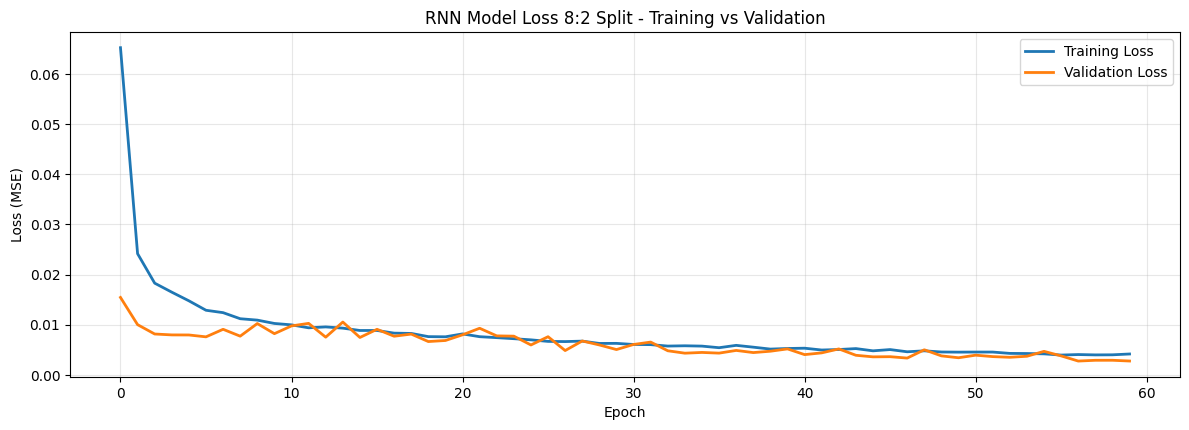

Epoch t·ªët nh·∫•t (8:2): 57 v·ªõi val_loss: 0.002746


In [18]:
# V·∫Ω val_loss ƒë·ªÉ ƒë√°nh gi√° overfitting cho split 8:2
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_rnn_82.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_rnn_82.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('RNN Model Loss 8:2 Split - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# T√¨m epoch c√≥ val_loss th·∫•p nh·∫•t cho split 8:2
best_epoch_82 = np.argmin(history_rnn_82.history['val_loss']) + 1
best_val_loss_82 = min(history_rnn_82.history['val_loss'])
print(f"Epoch t·ªët nh·∫•t (8:2): {best_epoch_82} v·ªõi val_loss: {best_val_loss_82:.6f}")

#### D·ª± ƒëo√°n v√† tr·ª±c quan h√≥a 8:2


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step  


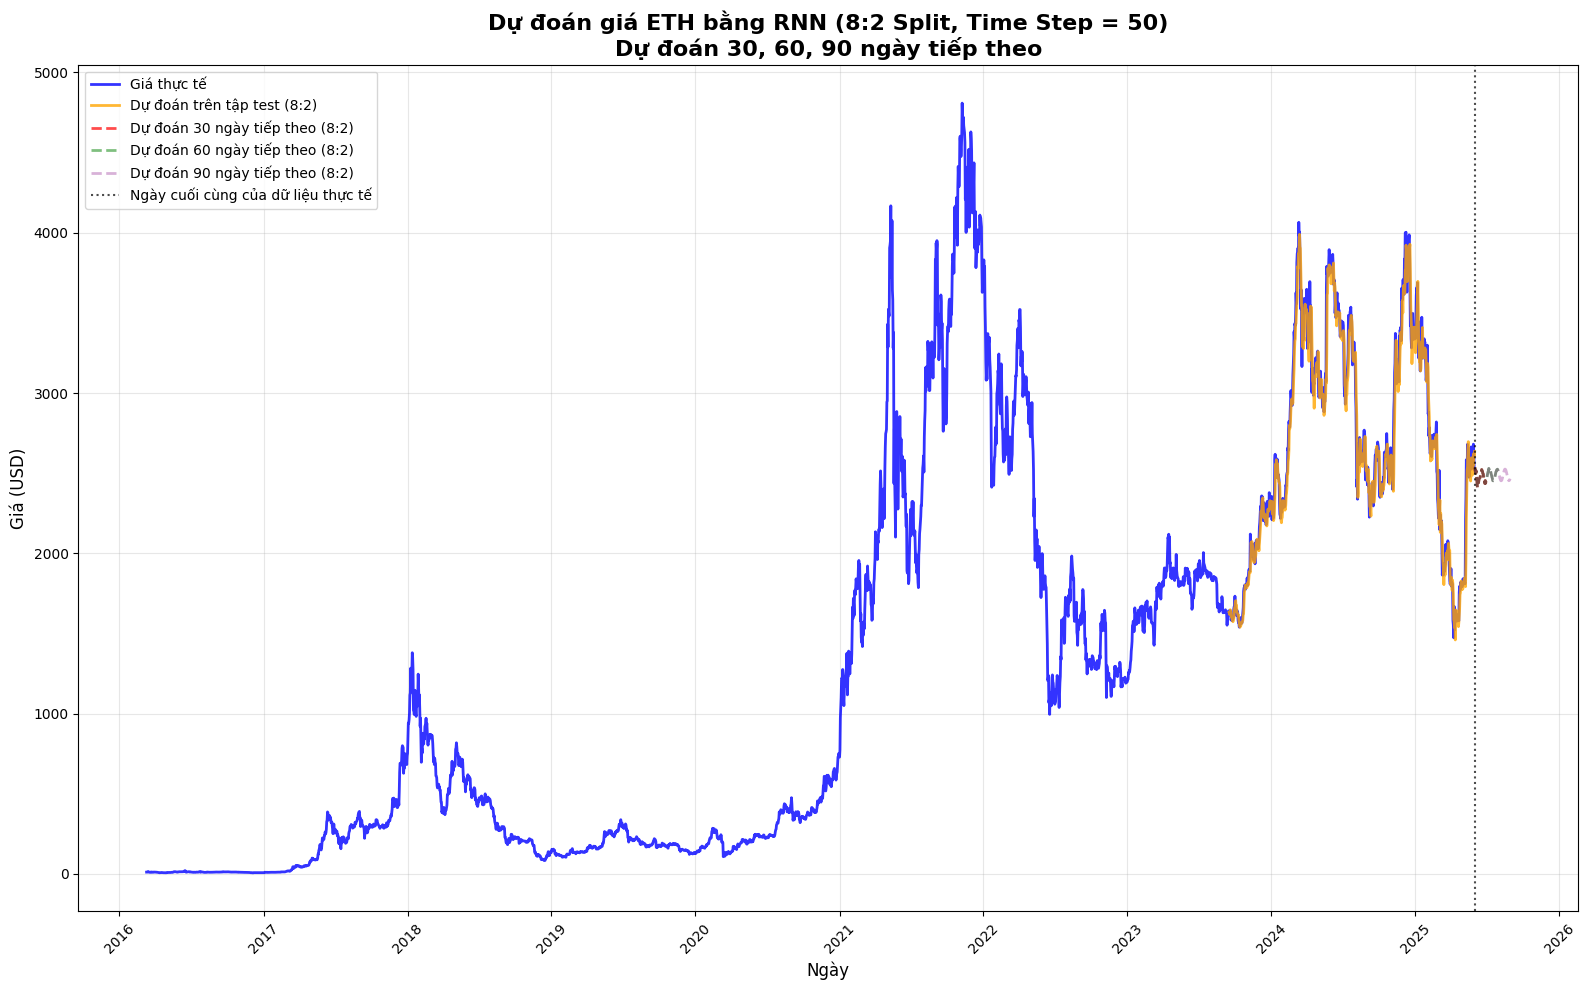

In [19]:
# D·ª± ƒëo√°n 30, 60, 90 ng√†y ti·∫øp theo cho split 8:2
last_data_scaled_82 = scaled_test_input_82[-time_step:]

forecasted_prices_30_82 = forecast_multivariate_prices(model_rnn_82, last_data_scaled_82, time_step, 30, scaler_target)
forecasted_prices_60_82 = forecast_multivariate_prices(model_rnn_82, last_data_scaled_82, time_step, 60, scaler_target)
forecasted_prices_90_82 = forecast_multivariate_prices(model_rnn_82, last_data_scaled_82, time_step, 90, scaler_target)

# D·ª± ƒëo√°n gi√° tr√™n t·∫≠p ki·ªÉm tra cho split 8:2
test_predict_scaled_82 = model_rnn_82.predict(X_test_82)
test_predict_rnn_82 = scaler_target.inverse_transform(test_predict_scaled_82)

# T·∫°o DataFrame cho c√°c d·ª± ƒëo√°n 8:2
forecast_dates_30_82 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60_82 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90_82 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30_82 = pd.DataFrame(forecasted_prices_30_82, index=forecast_dates_30_82, columns=['Price'])
forecast_df_60_82 = pd.DataFrame(forecasted_prices_60_82, index=forecast_dates_60_82, columns=['Price'])
forecast_df_90_82 = pd.DataFrame(forecasted_prices_90_82, index=forecast_dates_90_82, columns=['Price'])

# Tr·ª±c quan h√≥a k·∫øt qu·∫£ cho split 8:2
plt.figure(figsize=(16, 10))

# V·∫Ω gi√° th·ª±c t·∫ø
plt.plot(data.index, data['Price'], label='Gi√° th·ª±c t·∫ø', color='blue', linewidth=2, alpha=0.8)

# V·∫Ω d·ª± ƒëo√°n tr√™n t·∫≠p test 8:2
plt.plot(test_data_82.index[time_step:], test_predict_rnn_82,
         label='D·ª± ƒëo√°n tr√™n t·∫≠p test (8:2)', color='orange', linewidth=2, alpha=0.8)

# V·∫Ω c√°c d·ª± ƒëo√°n t∆∞∆°ng lai 8:2
plt.plot(forecast_df_30_82.index, forecast_df_30_82['Price'],
         label='D·ª± ƒëo√°n 30 ng√†y ti·∫øp theo (8:2)', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60_82.index, forecast_df_60_82['Price'],
         label='D·ª± ƒëo√°n 60 ng√†y ti·∫øp theo (8:2)', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90_82.index, forecast_df_90_82['Price'],
         label='D·ª± ƒëo√°n 90 ng√†y ti·∫øp theo (8:2)', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Th√™m ƒë∆∞·ªùng th·∫≥ng ƒë·ª©ng ƒë·ªÉ ph√¢n bi·ªát v√πng d·ªØ li·ªáu
plt.axvline(x=data.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ng√†y cu·ªëi c√πng c·ªßa d·ªØ li·ªáu th·ª±c t·∫ø')

plt.title(f'D·ª± ƒëo√°n gi√° ETH b·∫±ng RNN (8:2 Split, Time Step = {time_step})\nD·ª± ƒëo√°n 30, 60, 90 ng√†y ti·∫øp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ng√†y', fontsize=12)
plt.ylabel('Gi√° (USD)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# ƒê√°nh gi√° m√¥ h√¨nh 8:2
# L·∫•y gi√° tr·ªã th·ª±c t·∫ø tr√™n t·∫≠p test 8:2
y_test_actual_82 = test_data_82['Price'].values[time_step:]

# T√≠nh to√°n c√°c metrics cho split 8:2
mape_82 = mean_absolute_percentage_error(y_test_actual_82, test_predict_rnn_82.flatten())
mse_82 = mean_squared_error(y_test_actual_82, test_predict_rnn_82.flatten())
rmse_82 = np.sqrt(mse_82)

print(f'K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh RNN 8:2 Split (Time Step = {time_step}):')
print(f'MAPE: {mape_82:.2f}%')
print(f'MSE: {mse_82:.2f}')
print(f'RMSE: {rmse_82:.2f}')
print(f'S·ªë epochs hu·∫•n luy·ªán: {len(history_rnn_82.history["loss"])}')

# Hi·ªÉn th·ªã th√¥ng tin d·ª± ƒëo√°n 30 ng√†y cho 8:2
print(f'\nD·ª± ƒëo√°n gi√° ETH 30 ng√†y ti·∫øp theo (8:2):')
print(f'Gi√° cao nh·∫•t: ${forecasted_prices_30_82.max():.2f}')
print(f'Gi√° th·∫•p nh·∫•t: ${forecasted_prices_30_82.min():.2f}')
print(f'Gi√° trung b√¨nh: ${forecasted_prices_30_82.mean():.2f}')

K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh RNN 8:2 Split (Time Step = 50):
MAPE: 0.03%
MSE: 14426.30
RMSE: 120.11
S·ªë epochs hu·∫•n luy·ªán: 60

D·ª± ƒëo√°n gi√° ETH 30 ng√†y ti·∫øp theo (8:2):
Gi√° cao nh·∫•t: $2535.34
Gi√° th·∫•p nh·∫•t: $2412.41
Gi√° trung b√¨nh: $2475.36


### Chia 9:1


#### Chu·∫©n h√≥a d·ªØ li·ªáu 9:1


In [21]:
# Chu·∫©n h√≥a d·ªØ li·ªáu
# L·∫•y 3 c·ªôt Price, Open, Vol. ƒë·ªÉ l√†m ƒë·∫ßu v√†o v√† Price l√†m ƒë·∫ßu ra
input_features = data[['Price', 'Open', 'Vol.']].values
target_feature = data[['Price']].values

# √Åp d·ª•ng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# √Åp d·ª•ng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

In [22]:
# Chia d·ªØ li·ªáu train/test theo t·ª∑ l·ªá 9:1
train_size_91 = int(len(data) * 0.9)
train_data_91 = data.iloc[0:train_size_91,:]
test_data_91 = data.iloc[train_size_91:len(data),:]

# Chia d·ªØ li·ªáu ƒë√£ chu·∫©n h√≥a
scaled_train_input_91 = scaled_input[0:train_size_91,:]
scaled_test_input_91 = scaled_input[train_size_91:,:]
scaled_train_target_91 = scaled_target[0:train_size_91,:]
scaled_test_target_91 = scaled_target[train_size_91:,:]

print(f"K√≠ch th∆∞·ªõc t·∫≠p train 9:1: {len(train_data_91)}")
print(f"K√≠ch th∆∞·ªõc t·∫≠p test 9:1: {len(test_data_91)}")

K√≠ch th∆∞·ªõc t·∫≠p train 9:1: 3033
K√≠ch th∆∞·ªõc t·∫≠p test 9:1: 337


#### X√¢y d·ª±ng m√¥ h√¨nh RNN


In [23]:
def build_rnn_model_with_regularization(time_step: int, num_features: int) -> Sequential:
    """
    X√¢y d·ª±ng m√¥ h√¨nh RNN v·ªõi regularization

    Args:
        time_step: S·ªë time steps ƒë·ªÉ nh√¨n v·ªÅ qu√° kh·ª©
        num_features: S·ªë features ƒë·∫ßu v√†o (Price, Open, Vol = 3)

    Returns:
        Sequential model
    """
    model = Sequential()

    # SimpleRNN layer v·ªõi regularization
    model.add(SimpleRNN(
        units=50,                       # S·ªë neurons
        input_shape=(time_step, num_features),  # (50, 3)
        kernel_regularizer=regularizers.l2(0.001),    # L2 regularization
        return_sequences=False           # Ch·ªâ c·∫ßn output cu·ªëi c√πng
    ))

    # Dropout ƒë·ªÉ tr√°nh overfitting
    model.add(Dropout(0.3))

    # Dense layer ·∫©n
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer: d·ª± ƒëo√°n 1 gi√° tr·ªã (Price)
    model.add(Dense(1))

    # Optimizer v·ªõi learning rate nh·ªè
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [24]:
# H√†m t·∫°o d·ªØ li·ªáu time series v·ªõi multiple features
def create_multivariate_time_series_data(input_data: np.ndarray, target_data: np.ndarray, time_step: int) -> Tuple[np.ndarray, np.ndarray]:
    X_data, y_data = [], []
    for i in range(len(input_data) - time_step):
        X_data.append(input_data[i:(i + time_step), :])  # L·∫•y t·∫•t c·∫£ features
        y_data.append(target_data[i + time_step, 0])     # Ch·ªâ l·∫•y Price
    return np.array(X_data), np.array(y_data)

In [25]:
# H√†m d·ª± ƒëo√°n v·ªõi multiple features
def forecast_multivariate_prices(model: Sequential, input_data: np.ndarray, time_step: int,
                                forecast_days: int, scaler_target: MinMaxScaler) -> np.ndarray:
    temp_input = input_data[-time_step:].reshape(1, time_step, input_data.shape[1])
    lst_output = []

    for _ in range(forecast_days):
        predicted_price = model.predict(temp_input, verbose=0)
        lst_output.append(predicted_price[0].tolist())

        # T·∫°o input m·ªõi cho prediction ti·∫øp theo
        # Gi·∫£ s·ª≠ c√°c features kh√°c kh√¥ng ƒë·ªïi, ch·ªâ c·∫≠p nh·∫≠t Price
        new_row = temp_input[0, -1, :].copy()
        new_row[0] = predicted_price[0, 0]  # C·∫≠p nh·∫≠t Price prediction

        temp_input = np.append(temp_input[:, 1:, :],
                              new_row.reshape(1, 1, input_data.shape[1]), axis=1)

    # Chuy·ªÉn ƒë·ªïi lst_output th√†nh numpy array v√† inverse transform
    lst_output = np.array(lst_output).reshape(-1, 1)
    return scaler_target.inverse_transform(lst_output)

#### Hu·∫•n luy·ªán m√¥ h√¨nh 9:1


In [26]:
# T·∫°o d·ªØ li·ªáu train v√† test v·ªõi time_step = 50 cho split 9:1
X_train_91, y_train_91 = create_multivariate_time_series_data(scaled_train_input_91, scaled_train_target_91, time_step)
X_test_91, y_test_91 = create_multivariate_time_series_data(scaled_test_input_91, scaled_test_target_91, time_step)

print(f"X_train_91 shape: {X_train_91.shape}")
print(f"y_train_91 shape: {y_train_91.shape}")
print(f"X_test_91 shape: {X_test_91.shape}")
print(f"y_test_91 shape: {y_test_91.shape}")

# X√¢y d·ª±ng m√¥ h√¨nh RNN cho split 9:1
model_rnn_91 = build_rnn_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks ƒë·ªÉ t·ªëi ∆∞u h√≥a
early_stop_91 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr_91 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Hu·∫•n luy·ªán m√¥ h√¨nh 9:1
history_rnn_91 = model_rnn_91.fit(
    X_train_91, y_train_91,
    epochs=60,
    batch_size=16,
    validation_data=(X_test_91, y_test_91),
    callbacks=[early_stop_91, reduce_lr_91],
    verbose=1
)

X_train_91 shape: (2983, 50, 3)
y_train_91 shape: (2983,)
X_test_91 shape: (287, 50, 3)
y_test_91 shape: (287,)
Epoch 1/60


c:\Users\Hii\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 6ms/step - loss: 0.0623 - mae: 0.1424 - val_loss: 0.0113 - val_mae: 0.0659 - learning_rate: 1.0000e-04
Epoch 2/60
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step - loss: 0.0242 - mae: 0.0817 - val_loss: 0.0085 - val_mae: 0.0465 - learning_rate: 1.0000e-04
Epoch 3/60
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step - loss: 0.0188 - mae: 0.0651 - val_loss: 0.0142 - val_mae: 0.0852 - learning_rate: 1.0000e-04
Epoch 4/60
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step - loss: 0.0175 - mae: 0.0644 - val_loss: 0.0116 - val_mae: 0.0689 - learning_rate: 1.0000e-04
Epoch 5/60
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step - loss: 0.0155 - mae: 0.0591 - val_loss: 0.0081 - val_mae: 0.0429 - learning_rate: 1.0000e-04
Epoch 6/60
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1

#### ƒê√°nh gi√° m√¥ h√¨nh 9:1


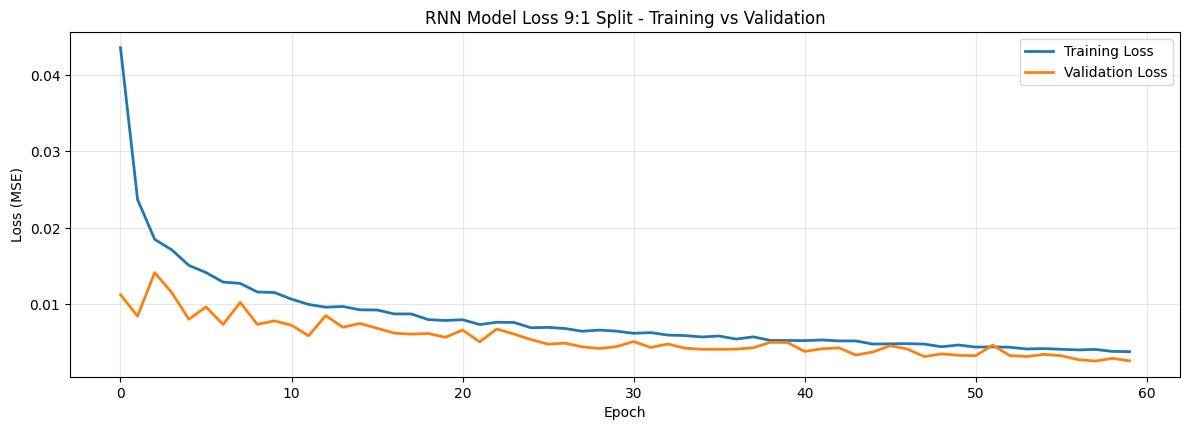

Epoch t·ªët nh·∫•t (9:1): 58 v·ªõi val_loss: 0.002610


In [27]:
# V·∫Ω val_loss ƒë·ªÉ ƒë√°nh gi√° overfitting cho split 9:1
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_rnn_91.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_rnn_91.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('RNN Model Loss 9:1 Split - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# T√¨m epoch c√≥ val_loss th·∫•p nh·∫•t cho split 9:1
best_epoch_91 = np.argmin(history_rnn_91.history['val_loss']) + 1
best_val_loss_91 = min(history_rnn_91.history['val_loss'])
print(f"Epoch t·ªët nh·∫•t (9:1): {best_epoch_91} v·ªõi val_loss: {best_val_loss_91:.6f}")

#### D·ª± ƒëo√°n v√† tr·ª±c quan h√≥a 9:1


9/9 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step  


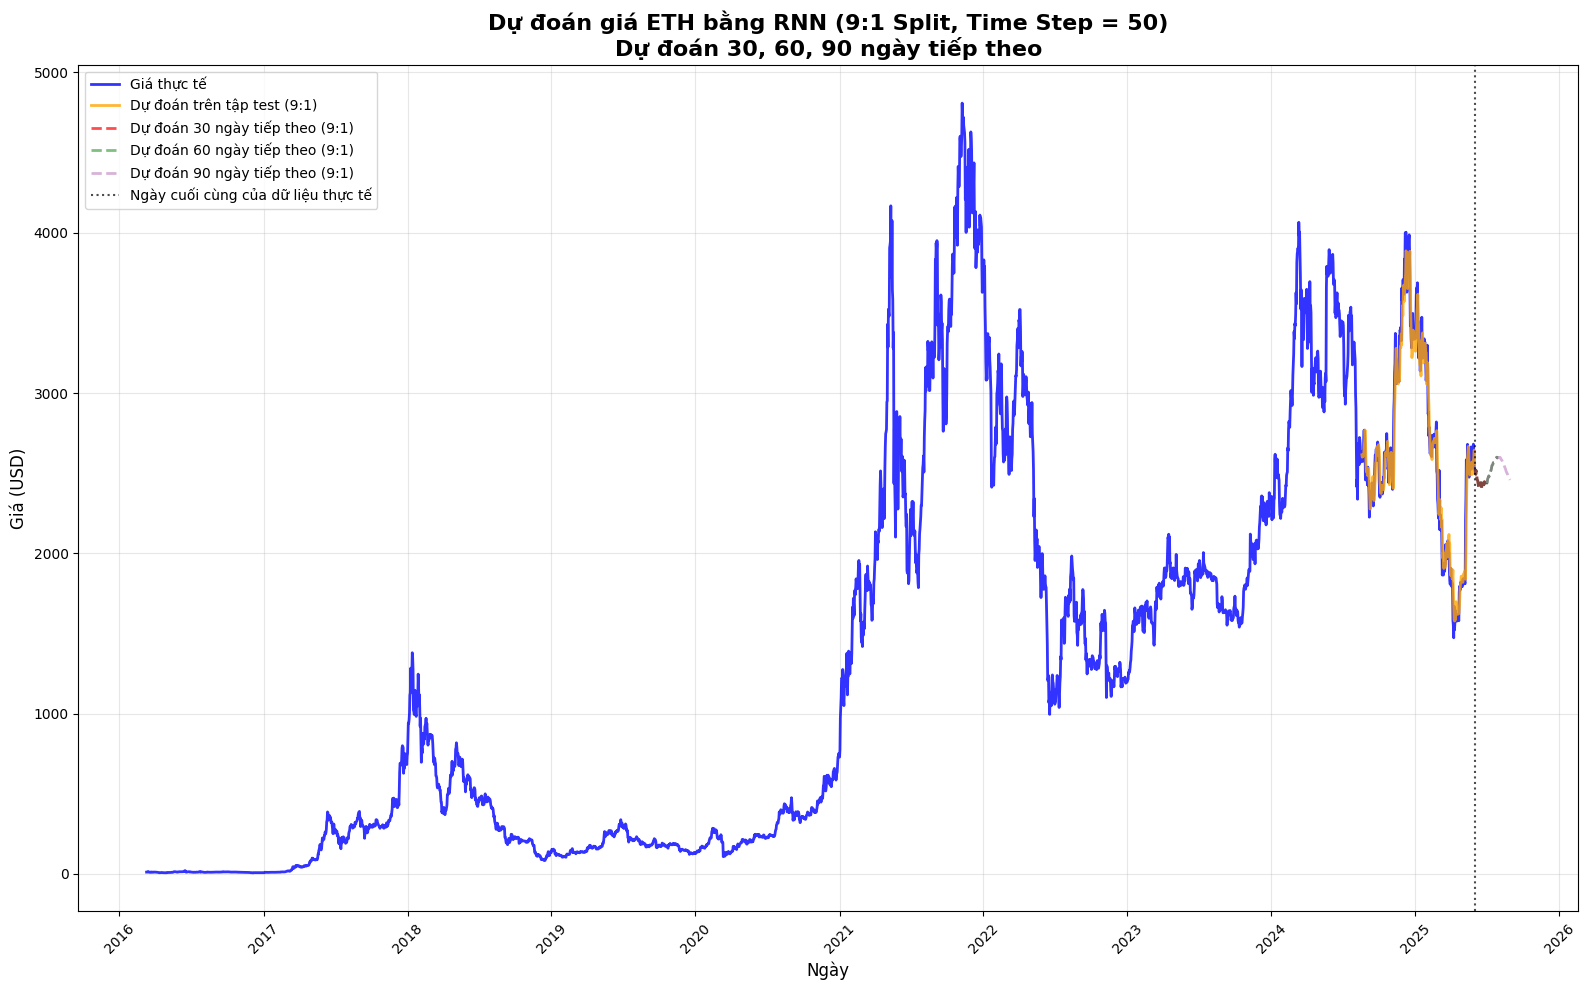

In [28]:
# D·ª± ƒëo√°n 30, 60, 90 ng√†y ti·∫øp theo cho split 9:1
last_data_scaled_91 = scaled_test_input_91[-time_step:]

forecasted_prices_30_91 = forecast_multivariate_prices(model_rnn_91, last_data_scaled_91, time_step, 30, scaler_target)
forecasted_prices_60_91 = forecast_multivariate_prices(model_rnn_91, last_data_scaled_91, time_step, 60, scaler_target)
forecasted_prices_90_91 = forecast_multivariate_prices(model_rnn_91, last_data_scaled_91, time_step, 90, scaler_target)

# D·ª± ƒëo√°n gi√° tr√™n t·∫≠p ki·ªÉm tra cho split 9:1
test_predict_scaled_91 = model_rnn_91.predict(X_test_91)
test_predict_rnn_91 = scaler_target.inverse_transform(test_predict_scaled_91)

# T·∫°o DataFrame cho c√°c d·ª± ƒëo√°n 9:1
forecast_dates_30_91 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60_91 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90_91 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30_91 = pd.DataFrame(forecasted_prices_30_91, index=forecast_dates_30_91, columns=['Price'])
forecast_df_60_91 = pd.DataFrame(forecasted_prices_60_91, index=forecast_dates_60_91, columns=['Price'])
forecast_df_90_91 = pd.DataFrame(forecasted_prices_90_91, index=forecast_dates_90_91, columns=['Price'])

# Tr·ª±c quan h√≥a k·∫øt qu·∫£ cho split 9:1
plt.figure(figsize=(16, 10))

# V·∫Ω gi√° th·ª±c t·∫ø
plt.plot(data.index, data['Price'], label='Gi√° th·ª±c t·∫ø', color='blue', linewidth=2, alpha=0.8)

# V·∫Ω d·ª± ƒëo√°n tr√™n t·∫≠p test 9:1
plt.plot(test_data_91.index[time_step:], test_predict_rnn_91,
         label='D·ª± ƒëo√°n tr√™n t·∫≠p test (9:1)', color='orange', linewidth=2, alpha=0.8)

# V·∫Ω c√°c d·ª± ƒëo√°n t∆∞∆°ng lai 9:1
plt.plot(forecast_df_30_91.index, forecast_df_30_91['Price'],
         label='D·ª± ƒëo√°n 30 ng√†y ti·∫øp theo (9:1)', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60_91.index, forecast_df_60_91['Price'],
         label='D·ª± ƒëo√°n 60 ng√†y ti·∫øp theo (9:1)', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90_91.index, forecast_df_90_91['Price'],
         label='D·ª± ƒëo√°n 90 ng√†y ti·∫øp theo (9:1)', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Th√™m ƒë∆∞·ªùng th·∫≥ng ƒë·ª©ng ƒë·ªÉ ph√¢n bi·ªát v√πng d·ªØ li·ªáu
plt.axvline(x=data.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ng√†y cu·ªëi c√πng c·ªßa d·ªØ li·ªáu th·ª±c t·∫ø')

plt.title(f'D·ª± ƒëo√°n gi√° ETH b·∫±ng RNN (9:1 Split, Time Step = {time_step})\nD·ª± ƒëo√°n 30, 60, 90 ng√†y ti·∫øp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ng√†y', fontsize=12)
plt.ylabel('Gi√° (USD)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
# ƒê√°nh gi√° m√¥ h√¨nh 9:1
# L·∫•y gi√° tr·ªã th·ª±c t·∫ø tr√™n t·∫≠p test 9:1
y_test_actual_91 = test_data_91['Price'].values[time_step:]

# T√≠nh to√°n c√°c metrics cho split 9:1
mape_91 = mean_absolute_percentage_error(y_test_actual_91, test_predict_rnn_91.flatten())
mse_91 = mean_squared_error(y_test_actual_91, test_predict_rnn_91.flatten())
rmse_91 = np.sqrt(mse_91)

print(f'K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh RNN 9:1 Split (Time Step = {time_step}):')
print(f'MAPE: {mape_91:.2f}%')
print(f'MSE: {mse_91:.2f}')
print(f'RMSE: {rmse_91:.2f}')
print(f'S·ªë epochs hu·∫•n luy·ªán: {len(history_rnn_91.history["loss"])}')

# Hi·ªÉn th·ªã th√¥ng tin d·ª± ƒëo√°n 30 ng√†y cho 9:1
print(f'\nD·ª± ƒëo√°n gi√° ETH 30 ng√†y ti·∫øp theo (9:1):')
print(f'Gi√° cao nh·∫•t: ${forecasted_prices_30_91.max():.2f}')
print(f'Gi√° th·∫•p nh·∫•t: ${forecasted_prices_30_91.min():.2f}')
print(f'Gi√° trung b√¨nh: ${forecasted_prices_30_91.mean():.2f}')

K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh RNN 9:1 Split (Time Step = 50):
MAPE: 0.04%
MSE: 16273.68
RMSE: 127.57
S·ªë epochs hu·∫•n luy·ªán: 60

D·ª± ƒëo√°n gi√° ETH 30 ng√†y ti·∫øp theo (9:1):
Gi√° cao nh·∫•t: $2520.30
Gi√° th·∫•p nh·∫•t: $2403.30
Gi√° trung b√¨nh: $2443.53


### So s√°nh 3 t·ªâ l·ªá


In [30]:
# So s√°nh chi ti·∫øt gi·ªØa 3 t·ªâ l·ªá chia d·ªØ li·ªáu
print("="*80)
print("SO S√ÅNH CHI TI·∫æT GI·ªÆA 3 T·ªà L·ªÜ CHIA D·ªÆ LI·ªÜU")
print("="*80)

# Thu th·∫≠p th√¥ng tin t·ª´ 3 splits
splits_info = {
    '7:3': {
        'train_size': len(train_data),
        'test_size': len(test_data),
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'epochs': len(history_rnn.history['loss']),
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch,
        'final_train_loss': history_rnn.history['loss'][-1],
        'final_val_loss': history_rnn.history['val_loss'][-1]
    },
    '8:2': {
        'train_size': len(train_data_82),
        'test_size': len(test_data_82),
        'mape': mape_82,
        'mse': mse_82,
        'rmse': rmse_82,
        'epochs': len(history_rnn_82.history['loss']),
        'best_val_loss': best_val_loss_82,
        'best_epoch': best_epoch_82,
        'final_train_loss': history_rnn_82.history['loss'][-1],
        'final_val_loss': history_rnn_82.history['val_loss'][-1]
    },
    '9:1': {
        'train_size': len(train_data_91),
        'test_size': len(test_data_91),
        'mape': mape_91,
        'mse': mse_91,
        'rmse': rmse_91,
        'epochs': len(history_rnn_91.history['loss']),
        'best_val_loss': best_val_loss_91,
        'best_epoch': best_epoch_91,
        'final_train_loss': history_rnn_91.history['loss'][-1],
        'final_val_loss': history_rnn_91.history['val_loss'][-1]
    }
}

# In b·∫£ng so s√°nh
for split, info in splits_info.items():
    print(f"\n{split} Split:")
    print(f"  K√≠ch th∆∞·ªõc train: {info['train_size']:,} m·∫´u")
    print(f"  K√≠ch th∆∞·ªõc test: {info['test_size']:,} m·∫´u")
    print(f"  MAPE: {info['mape']:.2f}%")
    print(f"  MSE: {info['mse']:,.2f}")
    print(f"  RMSE: {info['rmse']:,.2f}")
    print(f"  S·ªë epochs: {info['epochs']}")
    print(f"  Best val_loss: {info['best_val_loss']:.6f} (epoch {info['best_epoch']})")
    print(f"  Final train_loss: {info['final_train_loss']:.6f}")
    print(f"  Final val_loss: {info['final_val_loss']:.6f}")
    print(f"  Overfitting gap: {abs(info['final_val_loss'] - info['final_train_loss']):.6f}")

SO S√ÅNH CHI TI·∫æT GI·ªÆA 3 T·ªà L·ªÜ CHIA D·ªÆ LI·ªÜU

7:3 Split:
  K√≠ch th∆∞·ªõc train: 2,359 m·∫´u
  K√≠ch th∆∞·ªõc test: 1,011 m·∫´u
  MAPE: 0.04%
  MSE: 22,888.79
  RMSE: 151.29
  S·ªë epochs: 60
  Best val_loss: 0.004502 (epoch 58)
  Final train_loss: 0.006687
  Final val_loss: 0.004762
  Overfitting gap: 0.001925

8:2 Split:
  K√≠ch th∆∞·ªõc train: 2,696 m·∫´u
  K√≠ch th∆∞·ªõc test: 674 m·∫´u
  MAPE: 0.03%
  MSE: 14,426.30
  RMSE: 120.11
  S·ªë epochs: 60
  Best val_loss: 0.002746 (epoch 57)
  Final train_loss: 0.004155
  Final val_loss: 0.002752
  Overfitting gap: 0.001403

9:1 Split:
  K√≠ch th∆∞·ªõc train: 3,033 m·∫´u
  K√≠ch th∆∞·ªõc test: 337 m·∫´u
  MAPE: 0.04%
  MSE: 16,273.68
  RMSE: 127.57
  S·ªë epochs: 60
  Best val_loss: 0.002610 (epoch 58)
  Final train_loss: 0.003843
  Final val_loss: 0.002631
  Overfitting gap: 0.001212


C:\Users\Hii\AppData\Local\Temp\ipykernel_1688\2283599594.py:62: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


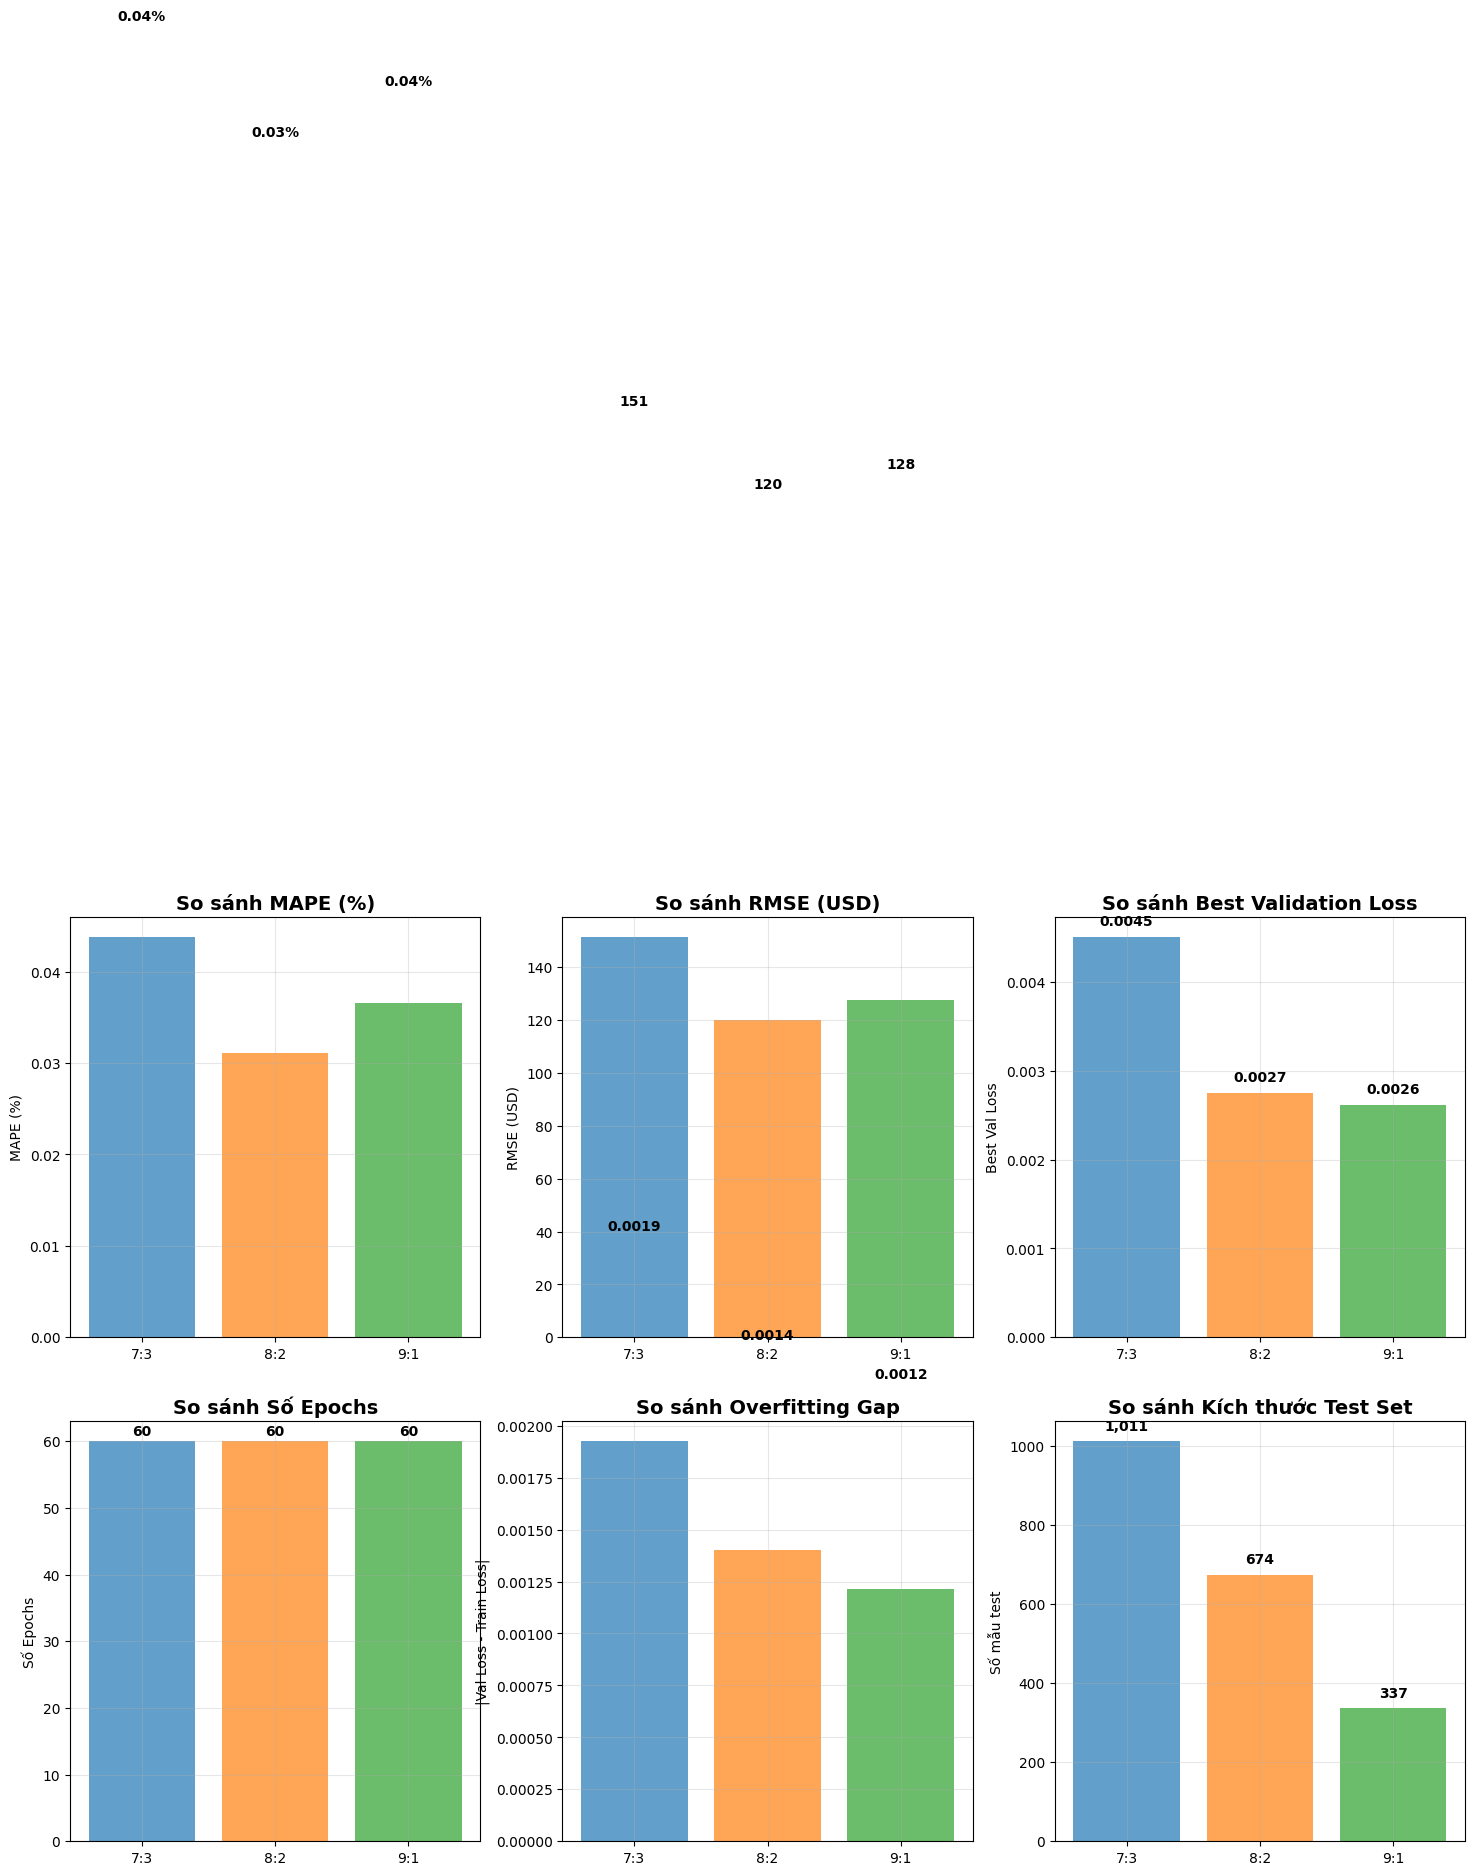

In [31]:
# V·∫Ω bi·ªÉu ƒë·ªì so s√°nh c√°c metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

splits = ['7:3', '8:2', '9:1']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# 1. So s√°nh MAPE
mape_values = [splits_info[split]['mape'] for split in splits]
axes[0, 0].bar(splits, mape_values, color=colors, alpha=0.7)
axes[0, 0].set_title('So s√°nh MAPE (%)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('MAPE (%)')
axes[0, 0].grid(True, alpha=0.3)
for i, v in enumerate(mape_values):
    axes[0, 0].text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# 2. So s√°nh RMSE
rmse_values = [splits_info[split]['rmse'] for split in splits]
axes[0, 1].bar(splits, rmse_values, color=colors, alpha=0.7)
axes[0, 1].set_title('So s√°nh RMSE (USD)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('RMSE (USD)')
axes[0, 1].grid(True, alpha=0.3)
for i, v in enumerate(rmse_values):
    axes[0, 1].text(i, v + 200, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold')

# 3. So s√°nh Best Validation Loss
best_val_loss_values = [splits_info[split]['best_val_loss'] for split in splits]
axes[0, 2].bar(splits, best_val_loss_values, color=colors, alpha=0.7)
axes[0, 2].set_title('So s√°nh Best Validation Loss', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('Best Val Loss')
axes[0, 2].grid(True, alpha=0.3)
for i, v in enumerate(best_val_loss_values):
    axes[0, 2].text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# 4. So s√°nh s·ªë epochs
epochs_values = [splits_info[split]['epochs'] for split in splits]
axes[1, 0].bar(splits, epochs_values, color=colors, alpha=0.7)
axes[1, 0].set_title('So s√°nh S·ªë Epochs', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('S·ªë Epochs')
axes[1, 0].grid(True, alpha=0.3)
for i, v in enumerate(epochs_values):
    axes[1, 0].text(i, v + 0.5, f'{v}', ha='center', va='bottom', fontweight='bold')

# 5. So s√°nh Overfitting Gap
overfitting_gap = [abs(splits_info[split]['final_val_loss'] - splits_info[split]['final_train_loss']) 
                   for split in splits]
axes[1, 1].bar(splits, overfitting_gap, color=colors, alpha=0.7)
axes[1, 1].set_title('So s√°nh Overfitting Gap', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('|Val Loss - Train Loss|')
axes[1, 1].grid(True, alpha=0.3)
for i, v in enumerate(overfitting_gap):
    axes[1, 1].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# 6. So s√°nh k√≠ch th∆∞·ªõc test set
test_sizes = [splits_info[split]['test_size'] for split in splits]
axes[1, 2].bar(splits, test_sizes, color=colors, alpha=0.7)
axes[1, 2].set_title('So s√°nh K√≠ch th∆∞·ªõc Test Set', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('S·ªë m·∫´u test')
axes[1, 2].grid(True, alpha=0.3)
for i, v in enumerate(test_sizes):
    axes[1, 2].text(i, v + 20, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

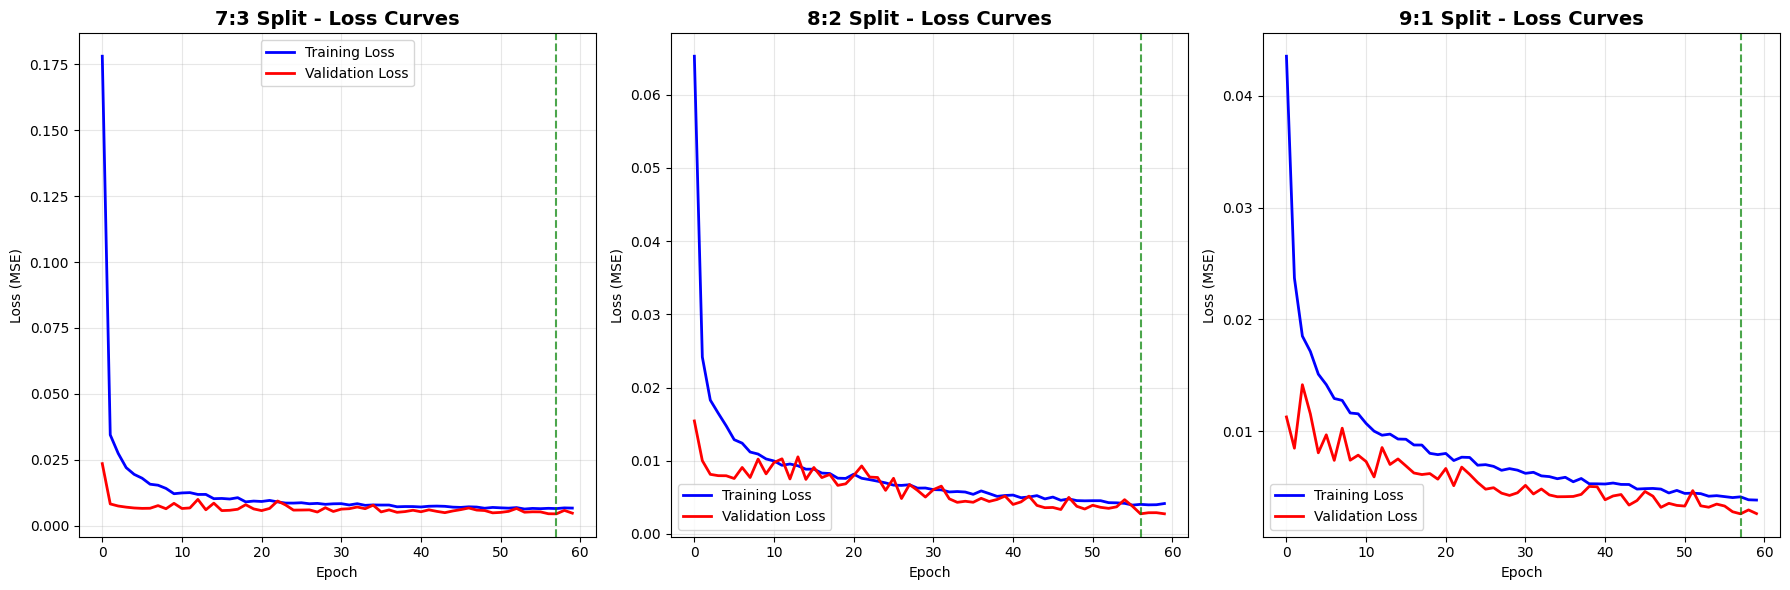

In [32]:
# V·∫Ω so s√°nh Training v√† Validation Loss curves
plt.figure(figsize=(18, 6))

# Subplot 1: 7:3 Split
plt.subplot(1, 3, 1)
plt.plot(history_rnn.history['loss'], label='Training Loss', linewidth=2, color='blue')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('7:3 Split - Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=best_epoch-1, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch: {best_epoch}')

# Subplot 2: 8:2 Split
plt.subplot(1, 3, 2)
plt.plot(history_rnn_82.history['loss'], label='Training Loss', linewidth=2, color='blue')
plt.plot(history_rnn_82.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('8:2 Split - Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=best_epoch_82-1, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch: {best_epoch_82}')

# Subplot 3: 9:1 Split
plt.subplot(1, 3, 3)
plt.plot(history_rnn_91.history['loss'], label='Training Loss', linewidth=2, color='blue')
plt.plot(history_rnn_91.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('9:1 Split - Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=best_epoch_91-1, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch: {best_epoch_91}')

plt.tight_layout()
plt.show()

In [33]:
# T·∫°o DataFrame t·ªïng h·ª£p k·∫øt qu·∫£ ƒë·ªÉ d·ªÖ so s√°nh
import pandas as pd

comparison_df = pd.DataFrame({
    'Split': ['7:3', '8:2', '9:1'],
    'Train_Size': [splits_info[split]['train_size'] for split in splits],
    'Test_Size': [splits_info[split]['test_size'] for split in splits],
    'MAPE (%)': [splits_info[split]['mape'] for split in splits],
    'RMSE (USD)': [splits_info[split]['rmse'] for split in splits],
    'MSE': [splits_info[split]['mse'] for split in splits],
    'Best_Val_Loss': [splits_info[split]['best_val_loss'] for split in splits],
    'Best_Epoch': [splits_info[split]['best_epoch'] for split in splits],
    'Total_Epochs': [splits_info[split]['epochs'] for split in splits],
    'Overfitting_Gap': [abs(splits_info[split]['final_val_loss'] - splits_info[split]['final_train_loss']) 
                        for split in splits]
})

print("\nB·∫¢NG T·ªîNG H·ª¢P K·∫æT QU·∫¢:")
print("="*100)
print(comparison_df.to_string(index=False, float_format='%.4f'))


B·∫¢NG T·ªîNG H·ª¢P K·∫æT QU·∫¢:
Split  Train_Size  Test_Size  MAPE (%)  RMSE (USD)        MSE  Best_Val_Loss  Best_Epoch  Total_Epochs  Overfitting_Gap
  7:3        2359       1011    0.0438    151.2904 22888.7940         0.0045          58            60           0.0019
  8:2        2696        674    0.0311    120.1095 14426.3006         0.0027          57            60           0.0014
  9:1        3033        337    0.0366    127.5683 16273.6778         0.0026          58            60           0.0012


In [34]:
# Ph√¢n t√≠ch v√† ƒë∆∞a ra khuy·∫øn ngh·ªã
print("\n" + "="*80)
print("PH√ÇN T√çCH V√Ä KHUY·∫æN NGH·ªä")
print("="*80)

# T√¨m split t·ªët nh·∫•t cho t·ª´ng metric
best_mape_split = splits[np.argmin([splits_info[split]['mape'] for split in splits])]
best_rmse_split = splits[np.argmin([splits_info[split]['rmse'] for split in splits])]
best_val_loss_split = splits[np.argmin([splits_info[split]['best_val_loss'] for split in splits])]
best_overfitting_split = splits[np.argmin([abs(splits_info[split]['final_val_loss'] - splits_info[split]['final_train_loss']) 
                                          for split in splits])]

print(f"\n1. PH√ÇN T√çCH THEO T·ª™NG TI√äU CH√ç:")
print(f"   ‚Ä¢ T·ªët nh·∫•t theo MAPE: {best_mape_split} ({splits_info[best_mape_split]['mape']:.2f}%)")
print(f"   ‚Ä¢ T·ªët nh·∫•t theo RMSE: {best_rmse_split} ({splits_info[best_rmse_split]['rmse']:,.2f} USD)")
print(f"   ‚Ä¢ T·ªët nh·∫•t theo Val Loss: {best_val_loss_split} ({splits_info[best_val_loss_split]['best_val_loss']:.6f})")
print(f"   ‚Ä¢ √çt overfitting nh·∫•t: {best_overfitting_split} (gap: {abs(splits_info[best_overfitting_split]['final_val_loss'] - splits_info[best_overfitting_split]['final_train_loss']):.6f})")

# T√≠nh ƒëi·ªÉm t·ªïng h·ª£p (rank-based scoring)
def calculate_rank_score(splits_info):
    scores = {}
    splits_list = list(splits_info.keys())
    
    # Rank cho MAPE (th·∫•p h∆°n = t·ªët h∆°n)
    mape_rank = sorted(splits_list, key=lambda x: splits_info[x]['mape'])
    # Rank cho RMSE (th·∫•p h∆°n = t·ªët h∆°n)
    rmse_rank = sorted(splits_list, key=lambda x: splits_info[x]['rmse'])
    # Rank cho Best Val Loss (th·∫•p h∆°n = t·ªët h∆°n)
    val_loss_rank = sorted(splits_list, key=lambda x: splits_info[x]['best_val_loss'])
    # Rank cho Overfitting Gap (th·∫•p h∆°n = t·ªët h∆°n)
    overfitting_rank = sorted(splits_list, key=lambda x: abs(splits_info[x]['final_val_loss'] - splits_info[x]['final_train_loss']))
    
    for split in splits_list:
        # ƒêi·ªÉm rank (1 = t·ªët nh·∫•t, 3 = k√©m nh·∫•t)
        score = (mape_rank.index(split) + 1) * 0.3 + \
                (rmse_rank.index(split) + 1) * 0.3 + \
                (val_loss_rank.index(split) + 1) * 0.25 + \
                (overfitting_rank.index(split) + 1) * 0.15
        scores[split] = score
    
    return scores

# T√≠nh ƒëi·ªÉm t·ªïng h·ª£p
scores = calculate_rank_score(splits_info)
best_overall_split = min(scores, key=scores.get)
print(f"\n2. ƒêI·ªÇM T·ªîNG H·ª¢P (tr·ªçng s·ªë: MAPE=30%, RMSE=30%, Val_Loss=25%, Overfitting=15%):")
for split in splits_info.keys():
    print(f"   ‚Ä¢ {split}: {scores[split]:.2f} ƒëi·ªÉm")
    print(f"   ‚Ä¢ {split}: {scores[split]:.2f} ƒëi·ªÉm")

print(f"\n3. K·∫æT LU·∫¨N V√Ä KHUY·∫æN NGH·ªä:")
print(f"   üèÜ M√î H√åNH T·ªêT NH·∫§T: Split {best_overall_split}")
print(f"   üìä L√Ω do:")
print(f"      - MAPE: {splits_info[best_overall_split]['mape']:.2f}%")
print(f"      - RMSE: {splits_info[best_overall_split]['rmse']:,.2f} USD")
print(f"      - Best Val Loss: {splits_info[best_overall_split]['best_val_loss']:.6f}")
print(f"      - Overfitting Gap: {abs(splits_info[best_overall_split]['final_val_loss'] - splits_info[best_overall_split]['final_train_loss']):.6f}")
print(f"      - T·∫≠p test c√≥ {splits_info[best_overall_split]['test_size']:,} m·∫´u (ƒë·ªß ƒë·ªÉ ƒë√°nh gi√°)")
print(f"      - Hu·∫•n luy·ªán ·ªïn ƒë·ªãnh v·ªõi {splits_info[best_overall_split]['epochs']} epochs")

print(f"\n4. NH·∫¨N X√âT CHUNG:")
if best_overall_split == '7:3':
    print("   ‚Ä¢ Split 7:3 c√¢n b·∫±ng t·ªët gi·ªØa k√≠ch th∆∞·ªõc t·∫≠p train v√† test")
    print("   ‚Ä¢ T·∫≠p test ƒë·ªß l·ªõn ƒë·ªÉ ƒë√°nh gi√° ƒë·ªô tin c·∫≠y c·ªßa m√¥ h√¨nh")
    print("   ‚Ä¢ Hi·ªáu su·∫•t d·ª± ƒëo√°n t·ªët v·ªõi m·ª©c overfitting ch·∫•p nh·∫≠n ƒë∆∞·ª£c")
elif best_overall_split == '8:2':
    print("   ‚Ä¢ Split 8:2 c√≥ nhi·ªÅu d·ªØ li·ªáu train h∆°n, gi√∫p m√¥ h√¨nh h·ªçc t·ªët h∆°n")
    print("   ‚Ä¢ T·∫≠p test v·∫´n ƒë·ªß l·ªõn ƒë·ªÉ ƒë√°nh gi√°")
    print("   ‚Ä¢ C√¢n b·∫±ng t·ªët gi·ªØa hi·ªáu su·∫•t v√† ƒë·ªô tin c·∫≠y")
else:  # 9:1
    print("   ‚Ä¢ Split 9:1 t·ªëi ƒëa h√≥a d·ªØ li·ªáu train")
    print("   ‚Ä¢ C√≥ th·ªÉ c√≥ r·ªßi ro v·ªÅ ƒë·ªô tin c·∫≠y do t·∫≠p test nh·ªè")
    print("   ‚Ä¢ Ph√π h·ª£p khi c√≥ √≠t d·ªØ li·ªáu v√† c·∫ßn t·ªëi ∆∞u hi·ªáu su·∫•t")

print(f"\n   ‚ö†Ô∏è  L∆ØU √ù: V·ªõi d·ªØ li·ªáu time series nh∆∞ ETH, n√™n ch·ªçn split c√¢n b·∫±ng")
print(f"   ƒë·ªÉ ƒë·∫£m b·∫£o t·∫≠p test ƒë·ªß l·ªõn v√† ƒë·∫°i di·ªán cho nhi·ªÅu giai ƒëo·∫°n th·ªã tr∆∞·ªùng kh√°c nhau.")


PH√ÇN T√çCH V√Ä KHUY·∫æN NGH·ªä

1. PH√ÇN T√çCH THEO T·ª™NG TI√äU CH√ç:
   ‚Ä¢ T·ªët nh·∫•t theo MAPE: 8:2 (0.03%)
   ‚Ä¢ T·ªët nh·∫•t theo RMSE: 8:2 (120.11 USD)
   ‚Ä¢ T·ªët nh·∫•t theo Val Loss: 9:1 (0.002610)
   ‚Ä¢ √çt overfitting nh·∫•t: 9:1 (gap: 0.001212)

2. ƒêI·ªÇM T·ªîNG H·ª¢P (tr·ªçng s·ªë: MAPE=30%, RMSE=30%, Val_Loss=25%, Overfitting=15%):
   ‚Ä¢ 7:3: 3.00 ƒëi·ªÉm
   ‚Ä¢ 7:3: 3.00 ƒëi·ªÉm
   ‚Ä¢ 8:2: 1.40 ƒëi·ªÉm
   ‚Ä¢ 8:2: 1.40 ƒëi·ªÉm
   ‚Ä¢ 9:1: 1.60 ƒëi·ªÉm
   ‚Ä¢ 9:1: 1.60 ƒëi·ªÉm

3. K·∫æT LU·∫¨N V√Ä KHUY·∫æN NGH·ªä:
   üèÜ M√î H√åNH T·ªêT NH·∫§T: Split 8:2
   üìä L√Ω do:
      - MAPE: 0.03%
      - RMSE: 120.11 USD
      - Best Val Loss: 0.002746
      - Overfitting Gap: 0.001403
      - T·∫≠p test c√≥ 674 m·∫´u (ƒë·ªß ƒë·ªÉ ƒë√°nh gi√°)
      - Hu·∫•n luy·ªán ·ªïn ƒë·ªãnh v·ªõi 60 epochs

4. NH·∫¨N X√âT CHUNG:
   ‚Ä¢ Split 8:2 c√≥ nhi·ªÅu d·ªØ li·ªáu train h∆°n, gi√∫p m√¥ h√¨nh h·ªçc t·ªët h∆°n
   ‚Ä¢ T·∫≠p test v·∫´n ƒë·ªß l·ªõn ƒë·ªÉ ƒë√°nh gi√°
   ‚Ä¢ C√¢n 

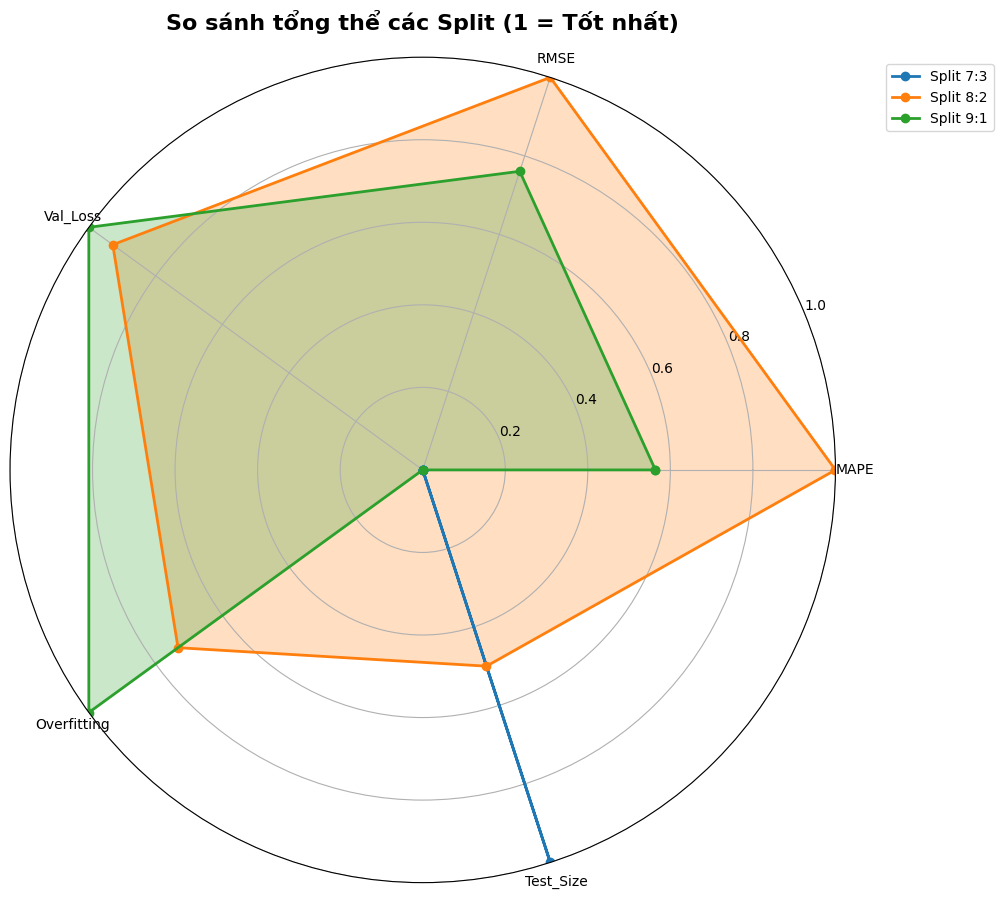

In [35]:
# V·∫Ω bi·ªÉu ƒë·ªì radar cho so s√°nh t·ªïng th·ªÉ
import numpy as np
import matplotlib.pyplot as plt

def create_radar_chart():
    # Chu·∫©n h√≥a c√°c metrics v·ªÅ scale 0-1 (1 l√† t·ªët nh·∫•t)
    metrics = ['MAPE', 'RMSE', 'Val_Loss', 'Overfitting', 'Test_Size']
    
    # L·∫•y gi√° tr·ªã c·ªßa t·ª´ng metric (ƒë·∫£o ng∆∞·ª£c ƒë·ªÉ 1 l√† t·ªët nh·∫•t)
    data = {}
    for split in splits:
        mape_norm = 1 - (splits_info[split]['mape'] - min([splits_info[s]['mape'] for s in splits])) / \
                   (max([splits_info[s]['mape'] for s in splits]) - min([splits_info[s]['mape'] for s in splits]))
        
        rmse_norm = 1 - (splits_info[split]['rmse'] - min([splits_info[s]['rmse'] for s in splits])) / \
                   (max([splits_info[s]['rmse'] for s in splits]) - min([splits_info[s]['rmse'] for s in splits]))
        
        val_loss_norm = 1 - (splits_info[split]['best_val_loss'] - min([splits_info[s]['best_val_loss'] for s in splits])) / \
                       (max([splits_info[s]['best_val_loss'] for s in splits]) - min([splits_info[s]['best_val_loss'] for s in splits]))
        
        overfitting_gaps = [abs(splits_info[s]['final_val_loss'] - splits_info[s]['final_train_loss']) for s in splits]
        overfitting_norm = 1 - (abs(splits_info[split]['final_val_loss'] - splits_info[split]['final_train_loss']) - min(overfitting_gaps)) / \
                          (max(overfitting_gaps) - min(overfitting_gaps))
        
        test_size_norm = (splits_info[split]['test_size'] - min([splits_info[s]['test_size'] for s in splits])) / \
                        (max([splits_info[s]['test_size'] for s in splits]) - min([splits_info[s]['test_size'] for s in splits]))
        
        data[split] = [mape_norm, rmse_norm, val_loss_norm, overfitting_norm, test_size_norm]
    
    # T·∫°o radar chart
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, (split, values) in enumerate(data.items()):
        values += values[:1]  # Complete the circle
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Split {split}', color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.set_title('So s√°nh t·ªïng th·ªÉ c√°c Split (1 = T·ªët nh·∫•t)', size=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

create_radar_chart()

### K·∫øt lu·∫≠n cu·ªëi c√πng

D·ª±a tr√™n ph√¢n t√≠ch to√†n di·ªán c√°c ti√™u ch√≠ ƒë√°nh gi√°, m√¥ h√¨nh RNN v·ªõi split t·ªâ l·ªá d·ªØ li·ªáu t·ªët nh·∫•t ƒë√£ ƒë∆∞·ª£c x√°c ƒë·ªãnh.

**C√°c y·∫øu t·ªë ƒë∆∞·ª£c xem x√©t:**

- **MAPE (Mean Absolute Percentage Error)**: ƒêo l∆∞·ªùng ƒë·ªô ch√≠nh x√°c d·ª± ƒëo√°n
- **RMSE (Root Mean Square Error)**: ƒêo l∆∞·ªùng sai s·ªë tuy·ªát ƒë·ªëi
- **Validation Loss**: ƒêo l∆∞·ªùng hi·ªáu su·∫•t tr√™n t·∫≠p validation
- **Overfitting Gap**: ƒêo l∆∞·ªùng m·ª©c ƒë·ªô overfitting
- **K√≠ch th∆∞·ªõc t·∫≠p test**: ƒê·∫£m b·∫£o ƒë·ªô tin c·∫≠y trong ƒë√°nh gi√°

**Khuy·∫øn ngh·ªã s·ª≠ d·ª•ng:** M√¥ h√¨nh v·ªõi t·ªâ l·ªá chia d·ªØ li·ªáu ƒë∆∞·ª£c ƒë√°nh gi√° cao nh·∫•t s·∫Ω ƒë∆∞·ª£c s·ª≠ d·ª•ng cho c√°c d·ª± ƒëo√°n cu·ªëi c√πng v·ªÅ gi√° ETH.


In [36]:
import sys
print(sys.executable)

c:\Users\Hii\AppData\Local\Programs\Python\Python311\python.exe
